# NLP Project - Determining users' game recommendations based on reviews.

## Loading Data and Imports

In [1]:
import numpy as np
import pandas as pd
import re
import spacy
import ast
import unicodedata
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
reviews = pd.read_csv('train.csv')
overview = pd.read_csv('game_overview.csv')

### The data comes from an Analytics Vidhyas competition found at: https://datahack.analyticsvidhya.com/contest/janatahack-nlp-hackathon/ 

In [4]:
reviews.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


### Reviews contain the users' reviews and the users' suggestions which will be used as the label. 1 = they would recommend the game, 0 = they would not.

In [5]:
overview.head()

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...
3,Fractured Space,Edge Case Games Ltd.,Edge Case Games Ltd.,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",Take the helm of a gigantic capital ship and g...
4,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...


### The overview data provides a lot more information on the game which could be used in the algorithm. Before I merge the datasets I will make sure there are no missing values and that there are no titles in reviews that aren't in overview.  

In [6]:
overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      64 non-null     object
 1   developer  64 non-null     object
 2   publisher  64 non-null     object
 3   tags       64 non-null     object
 4   overview   64 non-null     object
dtypes: object(5)
memory usage: 2.6+ KB


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


In [8]:
overview_games = set(overview.title.unique())
reviews_games = set(reviews.title.unique())
print("Games Titles present in reviews but not in overview", len(reviews_games - overview_games))

Games Titles present in reviews but not in overview 0


In [9]:
reviews = pd.merge(reviews,overview,left_on='title',right_on='title')
reviews.head()

,review_id,title,year,user_review,user_suggestion,developer,publisher,tags,overview
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...


### There are no missing values apart from the year, which won't be used in the model. There are no titles in reviews that do not appear in overview so we can merge the datasets. 

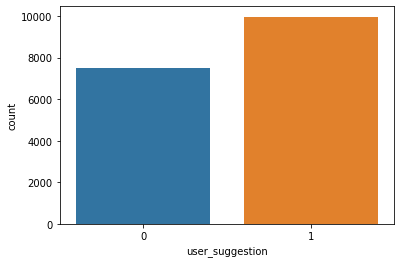

In [10]:
sns.countplot(data=reviews, x= reviews['user_suggestion'])

### A quick graph shows the proportions of 0 and 1 in 'user_suggestions'. They are not perfectly balanced but good enough to give a meaningful accuracy value. 

## Data Cleaning 

### First I will define some useful functions, then I will compile them into one cleaner function which will iterate over the 'user_review', 'title' and 'overview' column. 

In [11]:
is_ascii = lambda s: len(s) == len(s.encode())
non_ascii_idx = [idx for idx,user_review in enumerate(reviews['user_review'].values) if not is_ascii(user_review)]

In [12]:
import unicodedata
def remove_nonascii(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8', 'ignore')
    return text

### This function removes non-ASCII characters. To locate them I will compare the length of the string to its UTF-8 encoded version.  They will then be normalized and encoded into their ASCII equivalent, removing any non-ASCII characters. The string is then decoded back into UTF-8 which is the standard form for programming languages.

In [13]:
def remove_url(text):
    return re.sub("http[s]*://[^\s]+"," ", text)

In [14]:
def remove_spaces_punct_specialchars(text):
    text_sent = re.sub("[-!\"#$%&'()*+,./:;<=>?@\][^_`|}{~']"," ",text) 
    text_sent = text_sent.replace("\\"," ")
    text_sent = re.sub(r'\s+', ' ',text_sent)
    return text_sent

### These Functions remove any URLs, extra white space, punctuation and special characters. These features add little meaning to the sentence and will create noise in the model. 

### I will now define the cleaner function by compiling the above functions, removing stopwords and adding lemmatization.

In [15]:
def clean_corpus(dataframe,col_name):
    corpus = list(dataframe[col_name].values)  
    text_sent = [remove_nonascii(sent) for sent in corpus]
    text_sent = [remove_url(text) for text in text_sent]
    text_sent = [remove_spaces_punct_specialchars(text) for text in text_sent]
    text_sent = list(map(str.lower,text_sent))
    Docs = nlp.pipe(text_sent,disable=["ner","parser"])   
    #'ner' and 'parser' components are removed to improve run speed
    cleaned_corpus = []
    for Doc in Docs:
        Doc_text = []
        for token in Doc:
            if token.is_stop == False:
                Doc_text.append(token.lemma_)
                # Non-stop words are lemmatized and added to Doc_text
        cleaned_corpus.append(Doc_text)
    cleaned_corpus = [" ".join(cleaned_text) for cleaned_text in cleaned_corpus]
    return cleaned_corpus

In [16]:
reviews['user_review'] = clean_corpus(reviews, 'user_review')

In [17]:
reviews['title'] = clean_corpus(reviews, 'title')

In [18]:
reviews['overview'] = clean_corpus(reviews, 'overview')

### The 'tag' feature looks like a list of strings but is actually just one long string. It will need to be split into its separate tags.

In [19]:
type(reviews['tags'][0])

str

In [20]:
reviews['tags'][0]

"['Horror', 'Free to Play', 'Cute', 'First-Person', 'Singleplayer', 'Psychological Horror', 'Indie', 'Adventure', 'Dark', 'Funny', 'Atmospheric', 'Action', 'Walking Simulator', 'Survival', 'Survival Horror', 'Anime', 'Gore', 'Comedy', 'Multiplayer', 'Illuminati']"

In [21]:
def tag_cleaner(df,col_name):
    tags = [ast.literal_eval(tag) for tag in df[col_name].values] #Evaluates the strings into list of strings
    tags = [" ".join(set(tag)) for tag in tags]
    return np.array(tags) 

In [22]:
reviews['tags'] = tag_cleaner(reviews,'tags')

### Now the features have been cleaned, they can be vectorized and entered into the model. I will make a simple baseline model just using the user_review feature which can then be improved. 

In [23]:
X = reviews['user_review']
y= reviews['user_suggestion']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
pipeline = Pipeline([
    ('vectorize', CountVectorizer()),
    ('classifier', MultinomialNB())
])

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorize',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [27]:
mnb_review_predictions = pipeline.predict(X_test)

In [28]:
print(classification_report(mnb_review_predictions,y_test))
print(confusion_matrix(mnb_review_predictions, y_test))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2392
           1       0.87      0.85      0.86      3382

    accuracy                           0.84      5774
   macro avg       0.83      0.83      0.83      5774
weighted avg       0.84      0.84      0.84      5774

[[1948  444]
 [ 503 2879]]


### I chose a Multinomial Naive Bayes classifier for the baseline model as it runs significantly faster than other classifiers and is the go-to for NLP problems. The model gave an accuracy of 0.84, which isn't bad but let's see if this can be improved by adding the extra features.

In [29]:
vec_train = pd.DataFrame()
vec_test = pd.DataFrame()
cvec = CountVectorizer()
for feat in reviews.iloc[:,[1,3,7,8]]:
    X = reviews[feat]
    y= reviews['user_suggestion']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    cvec.fit(X_train)
    trans_feat_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
    trans_feat_test = pd.DataFrame(cvec.transform(X_test).todense(), columns = cvec.get_feature_names())
    vec_train = pd.concat([vec_train, trans_feat_train],axis =1)   
    vec_test = pd.concat([vec_test, trans_feat_test],axis =1)

In [30]:
print(vec_train.shape)
print(vec_test.shape)

(11720, 38263)
(5774, 38263)


### As I am vectorizing multiple columns, the pipeline I used previously would give a document-term matrix with an incorrect shape for the classifier. Instead, I fit and transform each column into a data frame which I then concatenate to form a sparse matrix with the correct shape for the classifier. 

In [31]:
mnb2 = MultinomialNB()

In [32]:
mnb2.fit(vec_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
mnb2_pred = mnb2.predict(vec_test)

In [34]:
print(classification_report(mnb2_pred,y_test))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      2785
           1       0.72      0.80      0.76      2989

    accuracy                           0.74      5774
   macro avg       0.74      0.73      0.73      5774
weighted avg       0.74      0.74      0.74      5774



### Adding the extra features did not increase the models' performance. This makes sense as the genre/title doesn't affect the quality of the game, especially considering the user would be picking a genre they already enjoy so there's little information to be gained here. 
### I experimented with using multiple classifiers and using TfidfTransformer but could not improve the baseline model.

## In conclusion, the baseline model gave the best performance with an accuracy of 0.84. This is a good result but not useable for a real-world application designed to predict if a user would recommend a game. The model could most likely be improved with more reviews and other information such as time played and a rating system. 
## Thank you for reading!